
# Using Machine Learning to Predict Wine Quality

*Individual assignment submitted by Verena Sarrazin as part of the CFG +Masters in AI & ML*

Dataset retrieved from: https://archive.ics.uci.edu/dataset/186/wine+quality

\
In this notebook, I am using different machine learning algorithms with the goal to predict quality ratings of wine. Wine is one of the most popular alcoholic drinks, with an average consumption of ~ 240ml per week in the UK [(source)](https://www.statista.com/statistics/288779/wine-alcohol-clearances-in-the-united-kingdom-uk-annually/#:~:text=Wine%20drinkers%20in%20the%20United,average%20of%20about%20204%20pence.). A good quality wine is often described as one that has 'personality' or 'layers of flavour'. However, it is unclear how these abstract terms relate to chemical characteristics. In this machine learning project, I am using machine learning models to predict wine quality based on a range of chemical properties. The aim is to
1. test how well wine quality can be predicted based on chemical proporties, and
2. which chemical properties most strongly contribute to wine quality.


Since the outcome variable includes discrete numerical values (integers from 1 to 10), this dataset can be analysed using regression or classification algorithms. I decided to apply regression analysis for the following reasons:

1. Since the variable is numeric, the values have a meaningful order (i.e. 1 < 2 < 3, etc.). Regression analysis exploits this property, wheres classification would treat these values as distinct unrelated categories).

2. In regression analysis, it is easier to work with rare values since regression analysis can exploit the quantitative relationships between the outcome values (e.g. quality ratings of 3 are rare, but regression analysis can take into account the similarity to ratings of 4 or 5).

3. Regression analysis naturally predicts the outcome variable on a continuum, which gives us additional information about the uncertainty of the prediction. For example, a predicted outcome value of 6.5 means that the algorithm is unsure whether a rating of 6 or 7 is more likely (whereas a classification algorithm would assign one of the two categories).



## Outline:

I. Read in data

II. Preprocessing


1. Missing data
2. Remove duplicate rows
3. Create a new variable
4. Train-test split
5. Distribution of the outcome variable
6. Distribution of the predictor variables
7. Log-transform variables with skewed distribution
8. Remove outliers
9. Standardisation of predictor variables

III. Exploratory Data Analysis

1. Correlation matrix
2. Visualisations of the relationship between selected predictors and the outcome variable
3. Conclusions from EDA

IV. Machine Learning Analysis
1. Linear Regression
2. Elastic Net Regression
3. Support Vector Regression
4. Random Forest Regression
5. Random Forest Regression with PCA

V. Model Evaluation

1. Performance metrics
2. Visualisations of model fit
3. Examination of predictors in the best model

VI. Discussion and Conclusions

</br>
</br>


In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold, RandomizedSearchCV, GridSearchCV, RepeatedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, mean_absolute_error, mean_squared_error, explained_variance_score
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectPercentile, f_classif
from scipy import stats
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.tree import plot_tree
from sklearn.svm import SVR
from scipy.stats import expon
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE

## I. Read in data

The following code reads in both the red wine and white wine datasets and combines them into one. I am creating a variable for the wine type (i.e. 'red' or 'white'). This variable might be useful for predicting wine quality, since quality might depend on different chemical properties depending on the wine type.

In [2]:
# Red wine
red = pd.read_csv('winequality-red.csv', delimiter=';')
red['type'] = 0
print('RED WINE')
print('Rows:', red.shape[0])
print('Columns:', red.shape[1],'\n')

# White wine
white = pd.read_csv('winequality-white.csv', delimiter=';')
white['type'] = 1
print('WHITE WINE')
print('Rows:', white.shape[0])
print('Columns:', white.shape[1],'\n')

# Combine both datasets
data = pd.concat([red, white])
print('FULL DATASET')
print('Rows:', data.shape[0])
print('Columns:', data.shape[1])


RED WINE
Rows: 1599
Columns: 13 

WHITE WINE
Rows: 4898
Columns: 13 

FULL DATASET
Rows: 6497
Columns: 13


In [3]:
# Display the first 5 rows of the combined dataset:
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0


The dataset includes the following variables:

**Predictor variables (continuous apart from 'type'):**
- fixed acidity
- volatile acidity
- citric acidity
- residual sugar
- chlorides
- free sulfur dioxide
- total sulfur dioxide
- density
- pH
- sulphates
- alcohol
- type: a variable I added above to differentiate between 'red' and 'white' wine

**Newly created predictor variable (continuous):**
- proportion free sulphur dioxide: I am creating this variable in section II.2. (ratio of free sulfur dioxide to total sulfur dioxide)

**Outcome variable:**
- quality: the outcome variable


**Summary statistics:**

The table below shows summary statistics for each variable. The *mean* and *median* (*50%*) are measures for the central tendency. *min* and *max* describe the minimum and maximum values, respectively. *std* is the standard deviation, and *25%* and *75%* are the upper and lower quartile, which describe the spread of the data.

The only categorical variable in this dataset is 'type' (i.e. red wine or white wine). As can be seen from the row numbers printed above, there are about 3 times as many white wines as red wines.



In [4]:
data.iloc[:,0:12].describe() # extract summary statistics for all continuous variables

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801,5.818378
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


# II. Pre-processing

1. Missing data
2. Create a new variable
3. Train-test split
4. Distribution of the outcome variable
5. Distribution of the predictor variables
6. Log-transform variables with skewed distribution
7. Remove outliers
8. Standardisation of predictor variables

## 1. Missing data

The output below shows that there are no missing data points (all variables have 6497 non-null values).

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6497 entries, 0 to 4897
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  type                  6497 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 710.6 KB


## 2. Remove duplicate rows

The code below tests how many duplicate rows there, and removes them from the dataset. The dataset does not include the name of the wine (or any other ID variable) which would help to determine whether identical rows are actual duplicates, or different wines that happen to have the same chemical properties. However, since most variables are decimal numbers, I consider it unlikely that two wines have identical values. Therefore, I am removing all duplicate rows.

In [6]:
print('Number of duplicate rows:', data.duplicated().sum())
data = data[~data.duplicated()]
print('Number of rows in dataset after removing duplicates:', data.shape[0])


Number of duplicate rows: 1177
Number of rows in dataset after removing duplicates: 5320


## 3. Create a new variable

The dataset contains two related variables, free sulfur dioxide and total sulfur dioxide. In the EDA section below, we can see that they are quite strongly correlated, which makes intuitive sense because they are dependent of one another. Here, I am creating a new variable 'Proportion free sulphur dioxide' ('free sulfur dioxide' / 'total sulfur dioxide') which might be another informative predictor of wine quality.

In [7]:
# Add new variable
data['proportion free sulphur dioxide'] = data['free sulfur dioxide'] / data['total sulfur dioxide']

## 4. Train-test split

To avoid information leakage, I will split up the dataset into training and testing sets now, so that my decisions for the remaining pre-processing steps will not be influenced by the testing dataset.

In [8]:
# Split up into predictors (X) and target variable (y)
X = data.drop(['quality'], axis=1)
y = data[['quality']]

# Split into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)
print('Training dataset:', X_train.shape[0], 'rows')
print('Testing dataset:', X_test.shape[0], 'rows')

Training dataset: 4256 rows
Testing dataset: 1064 rows


## 5. Distribution of the outcome variable

The outcome variable, 'wine quality', seems to be roughly normally distributed. More extreme values are rare compared to values close to the centre of the distribution. As explained above, regression analysis takes into account the numeric relationships between the values, so should still perform relatively well. However, I expect that predictions for more extreme quality values might be less accurate.

One approach to handling imbalanced datasets would be to over-sample the minority clasees (e.g. using [SMOTE algorithms](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html)). However, it is unclear how well such oversampling techniques would work given how rare some values are (3 or 9).

I will therefore fit regression models without accounting for imbalances in teh dataset, and will assess model accuracy for different quality ranges in the Model Evaluation section.

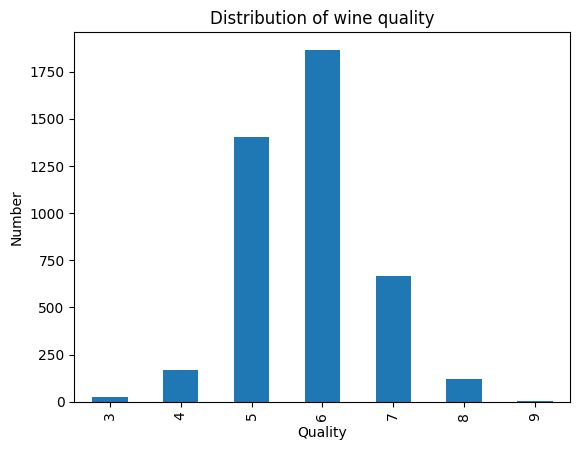

In [10]:
# Create count plot for the outcome variable
plt.figure()
y_train['quality'].value_counts()[[3, 4, 5, 6, 7, 8, 9]].plot(kind='bar')
plt.xlabel('Quality')
plt.ylabel('Number')
plt.title('Distribution of wine quality')
plt.show()

## 6. Distribution of the predictor variables

In the following part, I will apply different transformations to the data, and will plot the data before and after transformation. First, I am defining a function that plots histograms of the continuous predictor variables.

In [29]:
# Function definition to create histograms of the continuous predictor variables
def plot_distributions(X_train):
  continuous = X_train[['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'proportion free sulphur dioxide','density',
       'pH', 'sulphates', 'alcohol', 'type']]

  fig, axes = plt.subplots(3, 4, figsize=(20, 22))
  axes = axes.flatten()
  for i, var in enumerate(continuous.iloc[:, 0:12]):
      sns.histplot(data=continuous, x=var, hue= 'type',ax=axes[i], multiple="stack")
      axes[i].set_title(var)
  fig.subplots_adjust(top=0.92)
  fig.suptitle('Distributions of predictor variables', fontsize=20)
  plt.show()

I will start by plotting the raw data to identify any potential problems. Since the full dataset consists of two separaet datasets for red wine and white wine, I am colour-coding the wine type to assess if the variable distributions differ by wine type.

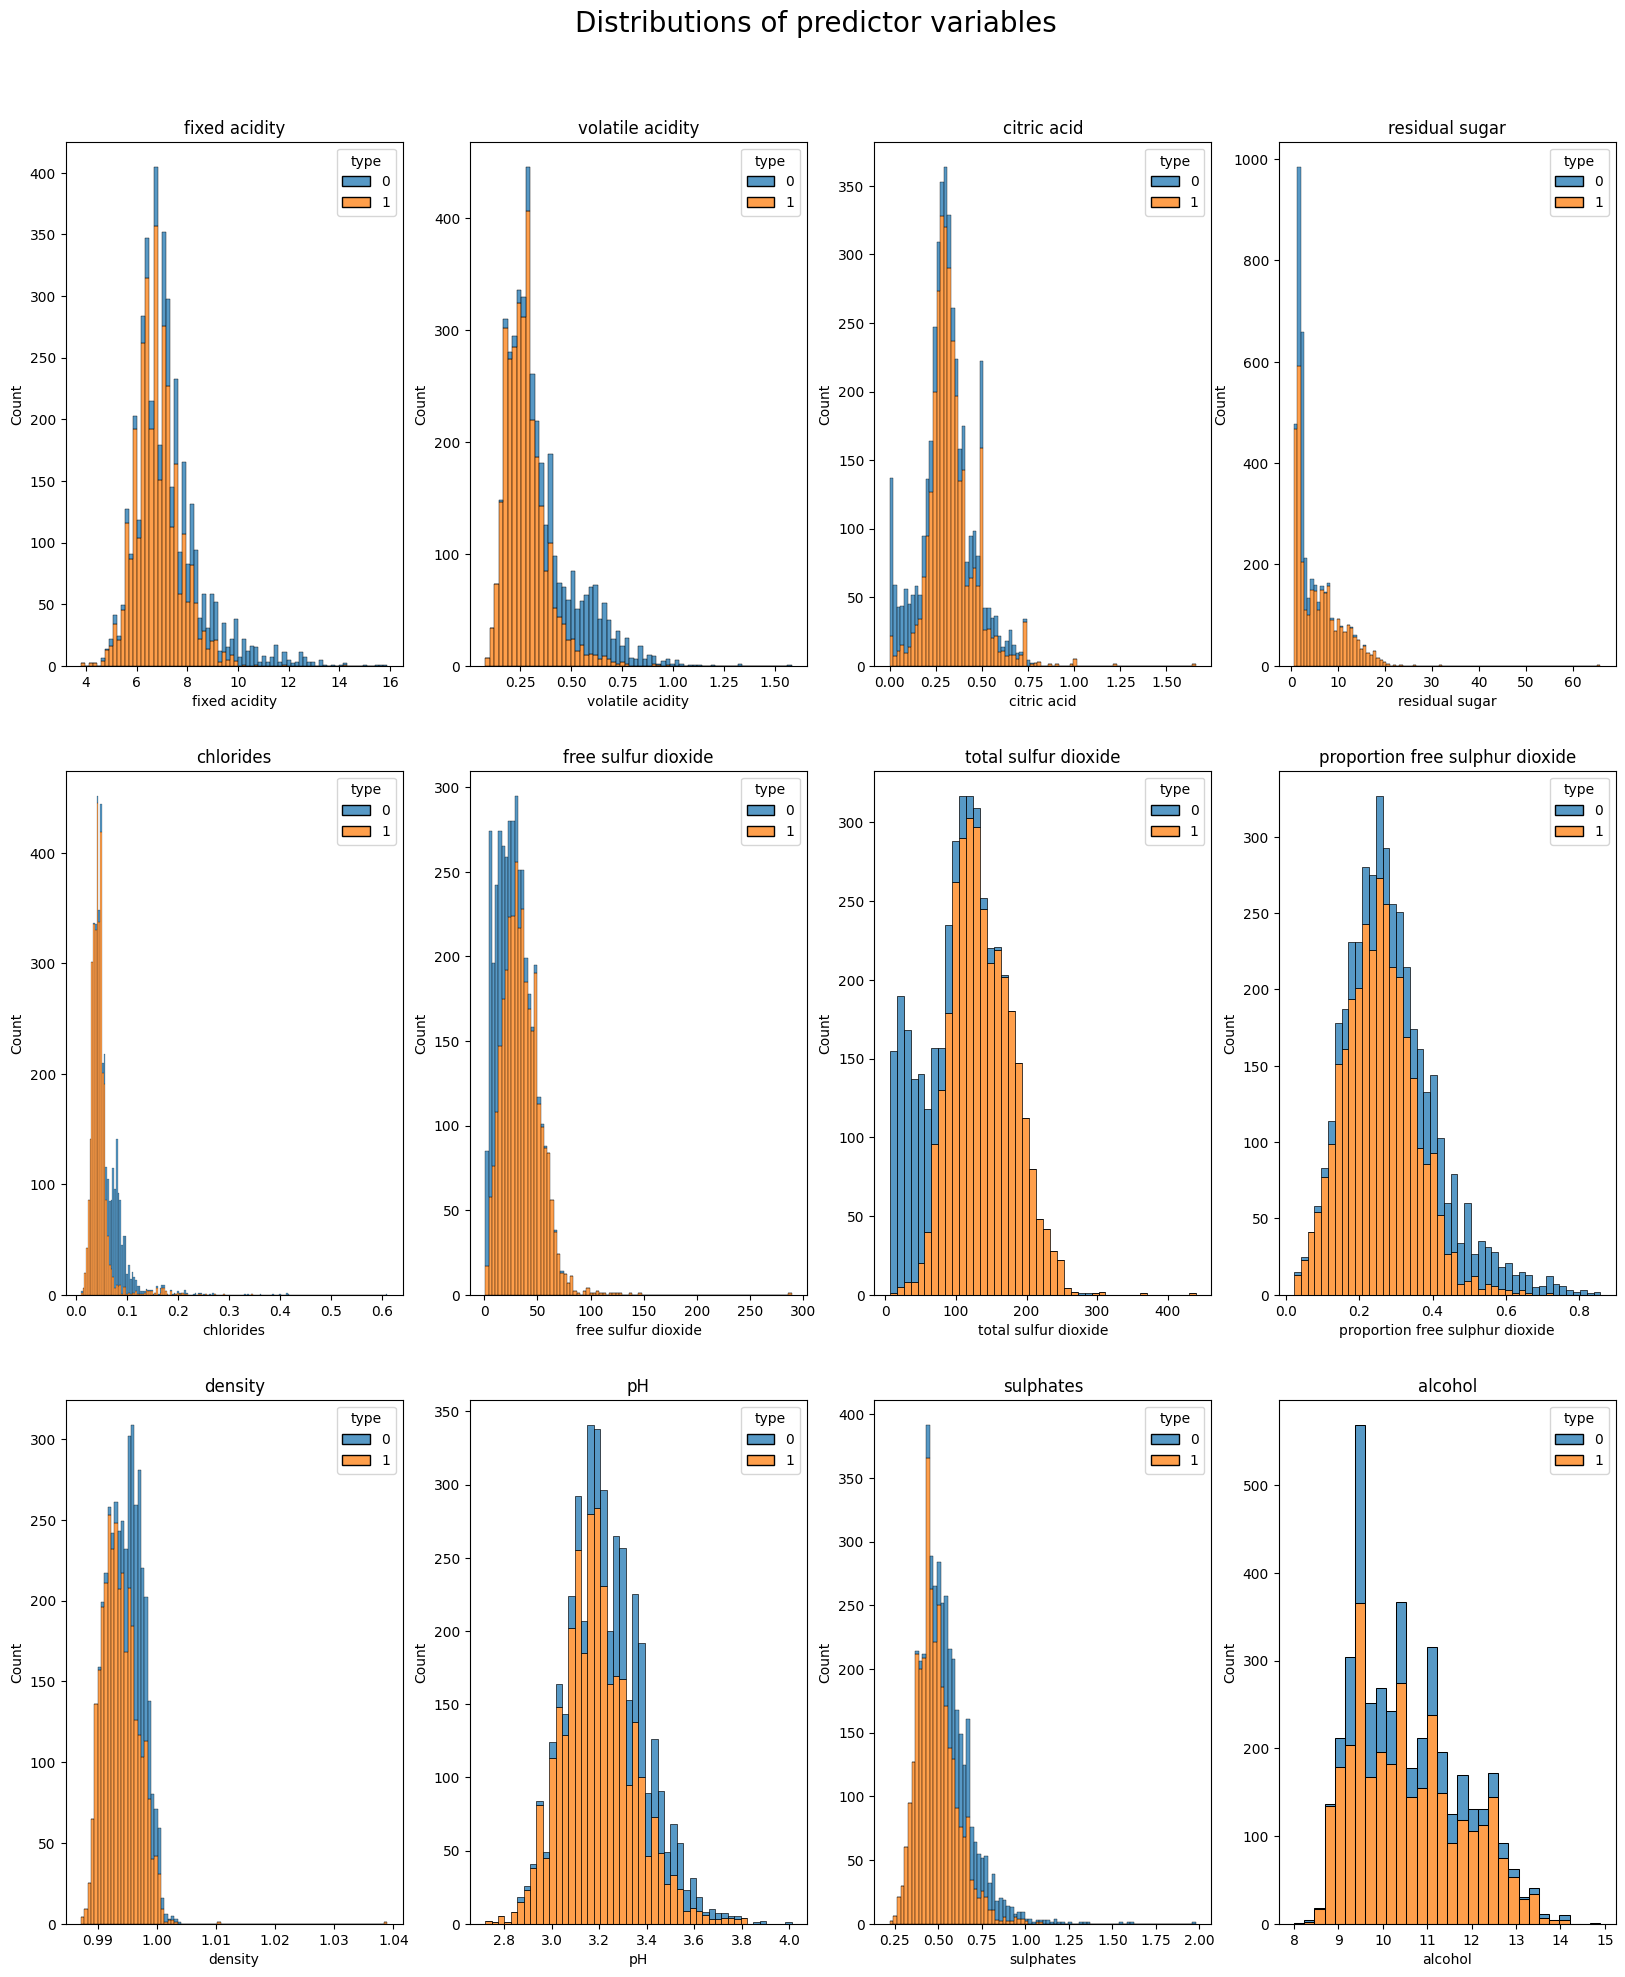

In [30]:
# Plot continuous predictor variables
plot_distributions(X_train)

The histograms show that some of the variables have a right-skewed distribtion (i.e. higher number of extreme values higher than the mean, see list of variables below). Skewed distribution can be problematic for machine learning analysis since they might lead to biased learning (see [here](https://machinelearningmastery.com/skewness-be-gone-transformative-tricks-for-data-scientists/)).

Moreover, there seem to be outliers in the data which can bias the machine learning algorithm and lead to inaccuarte conclusions and low performance.

The distribution for some variables seems to differ between white and red wine. For example, total sulfur dioxide has a clear bimodal distribution (white wine (1) has higher values than red wine (0)). This indicates that the type of wine might indeed be a useful predictor variable since the profile of chemical properties and their relationship to quality might differ.

## 7. Log-transform variables with skewed distribution

The following variables will be [log-transformed](https://machinelearningmastery.com/skewness-be-gone-transformative-tricks-for-data-scientists/) to normalise their right-skewed distribution:

- fixed acidity
- volatile acidity
- residual sugar
- chlorides
- sulphates
- alcohol
- proportion free sulphur dioxide

In [31]:
# Apply log-transformation to right-skewed data
X_train['fixed acidity'] = np.log(X_train['fixed acidity'])
X_train['volatile acidity'] = np.log(X_train['volatile acidity'])
X_train['residual sugar'] = np.log(X_train['residual sugar'])
X_train['chlorides'] = np.log(X_train['chlorides'])
X_train['sulphates'] = np.log(X_train['sulphates'])
X_train['alcohol'] = np.log(X_train['alcohol'])
X_train['proportion free sulphur dioxide'] = np.log(X_train['proportion free sulphur dioxide'])

X_test['fixed acidity'] = np.log(X_test['fixed acidity'])
X_test['volatile acidity'] = np.log(X_test['volatile acidity'])
X_test['residual sugar'] = np.log(X_test['residual sugar'])
X_test['chlorides'] = np.log(X_test['chlorides'])
X_test['sulphates'] = np.log(X_test['sulphates'])
X_test['alcohol'] = np.log(X_test['alcohol'])
X_test['proportion free sulphur dioxide'] = np.log(X_test['proportion free sulphur dioxide'])


## 8. Remove outliers

The distributions of some variables look like they might contain outliers (e.g. citric acid, free sulfur dioxide, total sulful dioxide, density). I will remove rows where any variable is more than 3 standard deviations away from the mean.

In [32]:
# Remove all rows that have at least one outlier
# Outliers are defined as data points more than 3 standard deviations below or above the mean
train = X_train.copy()
train['quality'] = y_train['quality']
train.head()
train = train[(np.abs(stats.zscore(X_train.iloc[:,0:11])) < 3).all(axis=1)]
print('Number of rows with outliers: ', X_train.shape[0] - train.shape[0])

Number of rows with outliers:  200


In [33]:
# Re-assign data frames
X_train = train.drop(['quality'], axis=1)
y_train = train[['quality']]

**Illustration of distributions after transformation and outlier removal:**

The histograms below show that the distributions look more symmetric now, and there are no more  potential outliers left that might bias the analysis.

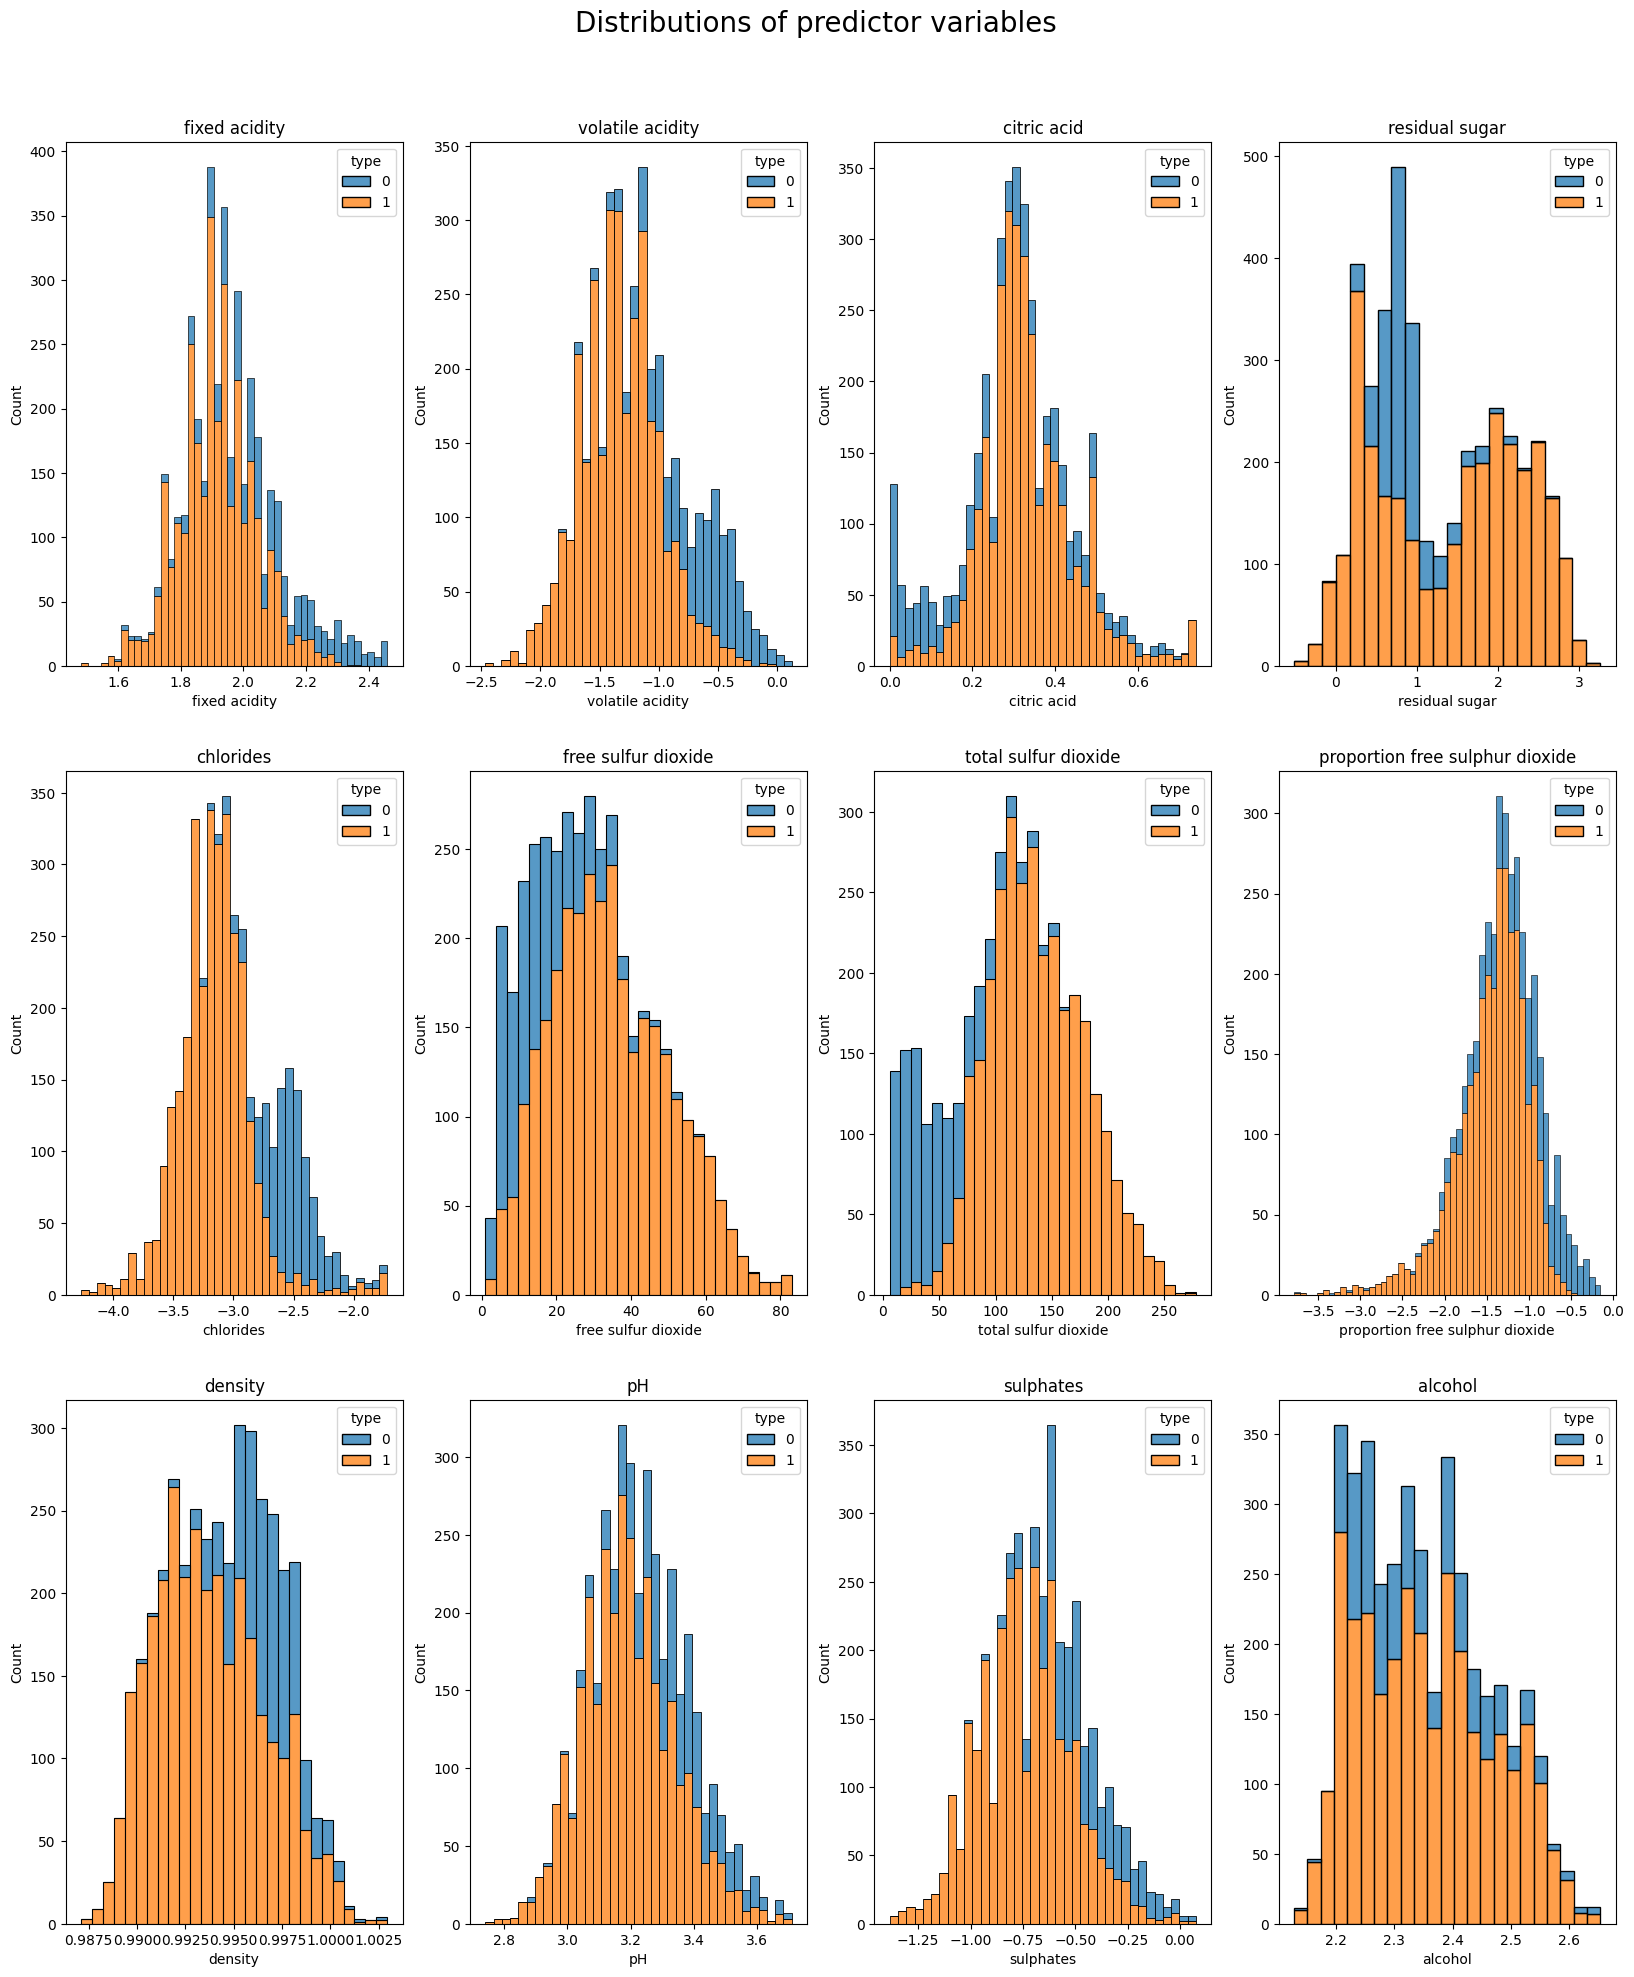

In [34]:
# Plot log-transformed data after outlier removal
plot_distributions(X_train)


## 9. Standardisation of predictor variables

Since the different variables have a different value ranges and different units, standardisation is required for most machine learning algorithms.

Importantly, standardisation is first applied to the training dataset only, to avoid information leakage between testing and training data. The same transformation is then applied to the testing data.

In [35]:
# Standardise training data
X_train_raw = X_train.copy() # keep copy of non-standardiesd data
scaler_train = preprocessing.StandardScaler().fit(X_train) # calculate transformation on training data
X_train = scaler_train.transform(X_train_raw) # apply tarnsformation to training data

# The testing data need to be standardised using the same transformation
X_test_raw = X_test.copy() # keep copy of non-standardiesd data
X_test = scaler_train.transform(X_test_raw) # apply the ame transformation that was applied to the training data

# III Exploratory Data Analysis

1. Correlation matrix
2. Visualisations of the relationship between selected predictors and the outcome variable

## 1. Correlation matrix

The correlation matrix below displays the correlation between all combinations of variables in the dataset. Positive correlation coefficients (red shades) indicate a positive linear relationship between variables (i.e. a high value of variable A tends to be associated with a high value of variable B), whereas negative correlation coefficients (blue shades) indicate a negative linear relationship (i.e. a high value of variable A tends to be associated with a low value of variable B).

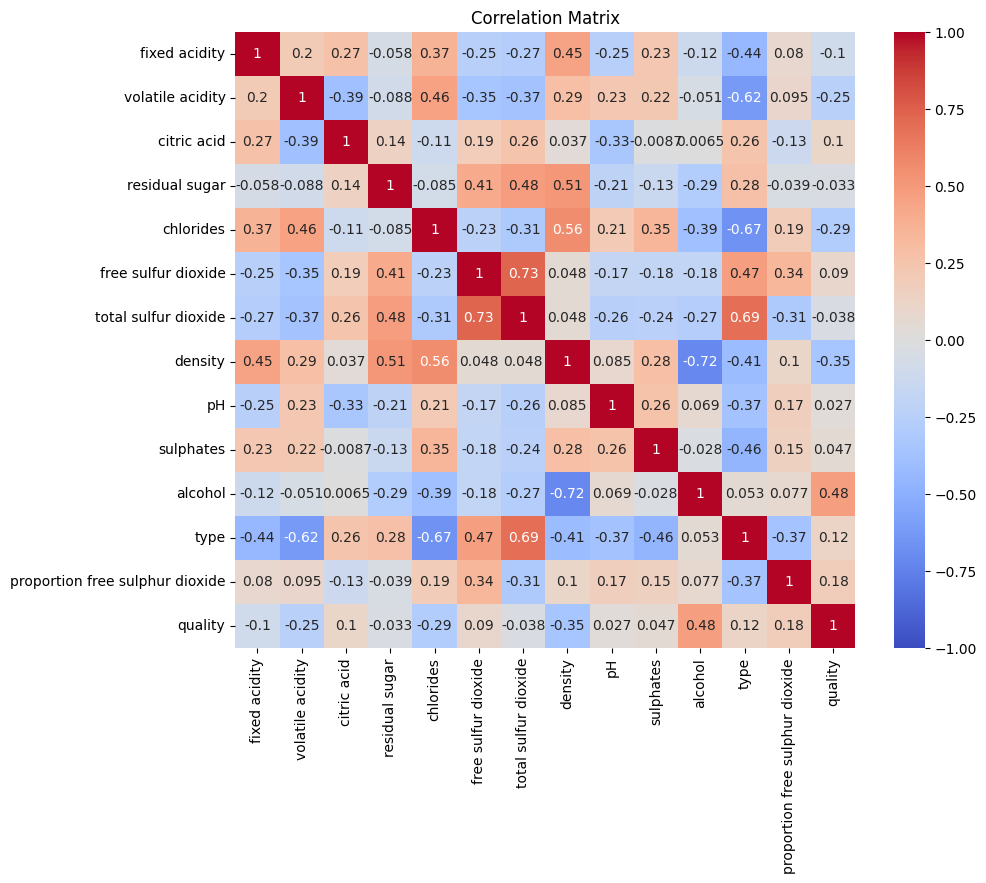

In [36]:
# Correlations
correlation_matrix = train.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

*Correlations with outcome variable:*

- Quality is most strongly correlated to alcohol content (0.45), density (-0.32), chlorides (-0.28) and volatile acidity (-0.26).
- Interestingly, the newly created variable 'proportion free sulfur dioxide' is more strongly correlated to the predictor variable than either of the variables it was created from (free and total sulfur dioxide)


*Correlations between predictors:*

- As explained above, total sulfur dioxide and free sulfur dioxide are quite strongly correlated (0.73) since they are dependent on one another. The proportion of free sulphur dioxide might be a more useful measure (it is correlated with the other two sulphur measures, but only moderately).

- Alcohol and density show a relatively strong negative relationship (-0.73).

- Chlorides and type of wine show a clear relationship as well. This is in line with the bimodal distribution in the chloride histogram (red and white wine have a different peak).

<u>**Conclusions**:</u>

Since some predictor variables show moderate to strong correlations, it is worth considering feature selection steps in the machine learning pipeline.



## 2. Visualisations of the relationship between selected predictors and outcome variable

The code below visualises the relationship between the four predictor variables which show the strongest correlation with the outcome variable. The heatmap shows the bivariate distribution of data points, and the regression line indicates the direction of the relationship.

In line with the correlation matrix, we can see that alcohol shows a positive relationship with quality, whereas density, chlorides and volatile acidity show negative relationships (i.e. the lower the value of the predictor variable, the higher the quality).

Correlations between wine quality and selected predictors


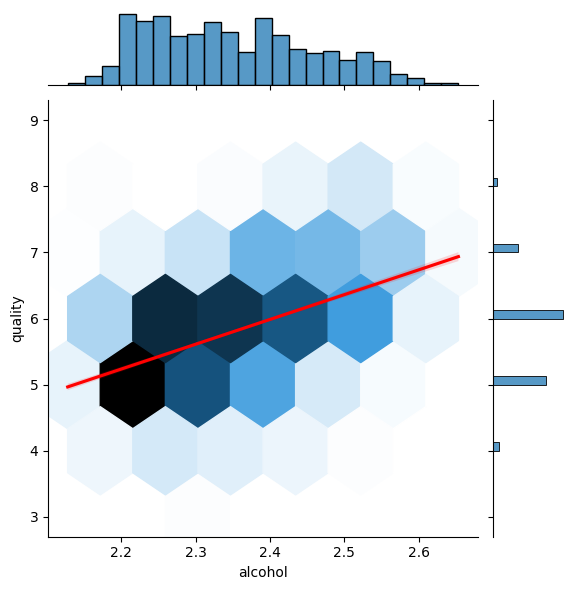

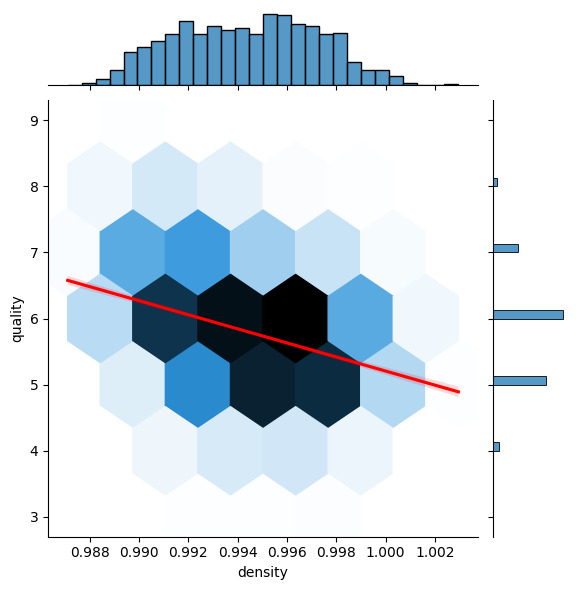

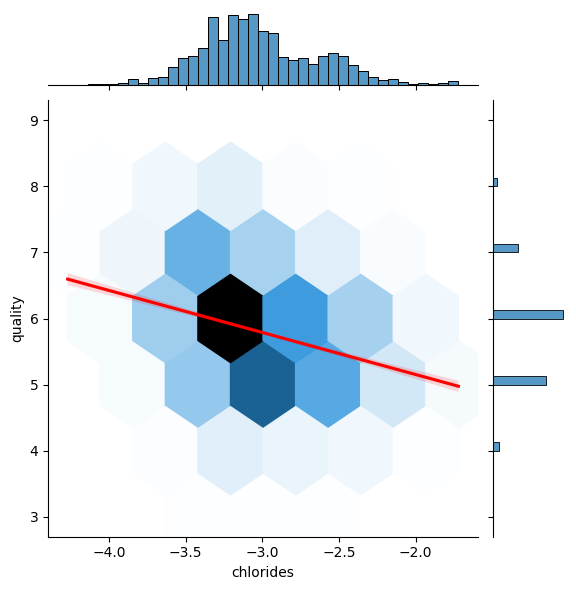

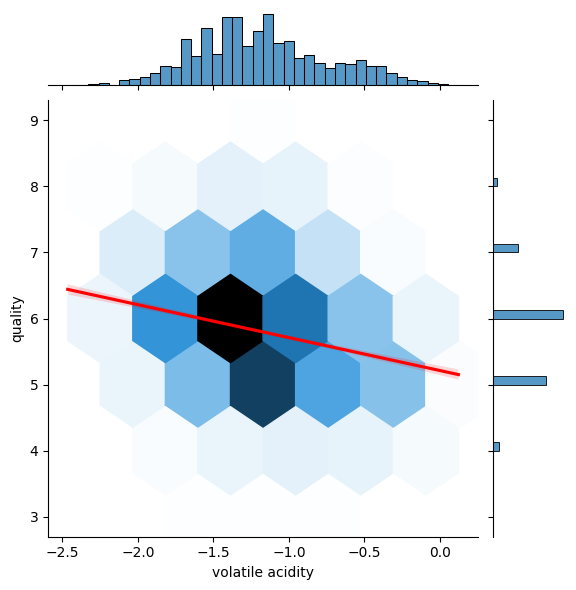

In [38]:
# Plot bivariate histograms to explore relationship between predictor variables and outcome variable
strongest_corr = train[['alcohol', 'density', 'chlorides', 'volatile acidity', 'quality']]

print('Correlations between wine quality and selected predictors')

for i, var in enumerate(strongest_corr.iloc[:, 0:4]):
    g = sns.jointplot(train, x=var, y='quality', kind="hex", gridsize=6)
    sns.regplot(train, x=var, y='quality', ax=g.ax_joint, scatter=False, color='red')
    plt.show()


**Wine type**

Let's see if red and white wines differ in their distribution of quality. The figure below suggests that white wine (1) might have slightly higher quality on average than red wine (0), since white wine has a higher mode than red wine (6 compared to 5). This again suggest that wine type might be a useful predictor for wine quality.

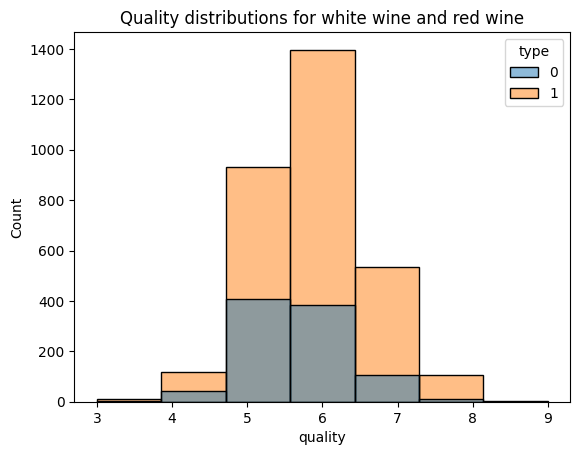

In [39]:
# Wine type
plt.figure()
sns.histplot(data=train, x='quality', hue= 'type',bins=7)
plt.title('Quality distributions for white wine and red wine')
plt.show()

## 3. Conclusions from EDA

1. Some predictor variables show a clear relationship with outcome variables, others do not. This might mean that some variables might not be useful for prediction of quality. However, it might be that some variables show a more complex relationship with quality, which is not visible in the correlation matrix or bivariate histograms.

2. Some predictors are quite highly correlated which can lead to overfitting and instability in model prediction.

3. Given 1. and 2., it might be useful to explore techniques of feature selection and dimensionality reduction to ensure accuracy and generalisability of the machine learning models.

# IV. Machine Learning Analysis

In this section, I will fit different machine learning models to the dataset. The general procedure consists of the following steps:

</br>

### 1. Model specification

The first step is to choose a suitable machine learning model. As explained in the introduction, I am using regression analysis to predict wine quality as continuous outcome measure. I am comparing the performance of five models: Linear regression, elastic net regression, support vector regression, random forest regression, and random forest regression using PCA for dimensionality reduction.

### 2. Model fitting

The models are fitted to the training data using maximum likelihood or gradient descent techniques (to minimise a loss function).

### 3. Cross-validation

A critical step for machine learning analysis is cross-validation, a procedure used to optimise model hyperparameters and performance evaluation in held-out validation subsets. I am using 10-fold cross-validation, which means the training dataset is split into 10 equal subsets. 9 subsets serve as training dataset, and one subset as validation dataset. The model is fitted to the training data and evaluated on the validation data. The whole procedure is repeated 10 times, so that each subset serves as validation dataset once.

### 4. Hyperparameter tuning

To optimise the model hyperparameters, the model is fitted repeatedly using different hyperparameter values. This is integrated into the cross-validation procedure. The best hyperparameter values will be determined based on the performance of the models in the validation subsets. Hyperparameter tuning can be performed using all possible combinations of parameter values (*GridSearchCV*) or by sampling a fixed number of parameter combinations from the parameter space (*RandomizedSearchCV*).


### 5. Performance evaluation in testing dataset

The performance of the final model (after refitting using the best combination of hyperparameters) is evaluated on the unseen testing data. Model performance will be assessed using the following performance metrics suitable for regression analysis:

- **Mean Absolute Error (MAE):** This is the mean of the absolute deviation of each predicted data point from the actual data point. The smaller the MAE is, the more accurate the prediction.

- **Mean Squared Error (MSE):** This is the mean of the squared deviation of each predicted data point from the actual data point. Compared to the MSE, it is more strongly influenced by very large deviations. It can be useful if it is important to avoid very larger deviations. The unit is difficult to interpret (because it is squared). A smaller the MSE is indicates a more accurate prediction.

- **Variance Explained:** This is a more intuitive measure representing the proportion of variance in the data that is accounted for by the model prediction. Larger values indicate better model fit.


### 6. Visualisation

The performance of all models is visualised in section V.


## 1. Linear Regression (baseline model)

I will start by fitting a very simple linear regression model to the data, which will serve as a baseline (no cross-validation or hyperparameter tuning). I will compare the performance of more complex models to this baseline model to assess the extent to which model complexity and hyperparameter tuning can improve model prediction.

In [40]:
# Set up linear regression model
LR = LinearRegression()

# Fit model to training data
LR.fit(X_train, np.ravel(y_train))

# Apply model to testing data
y_pred = LR.predict(X_test)

# Performance metrics for testing dataset
MAE_LR = mean_absolute_error(y_test, y_pred)
MSE_LR = mean_squared_error(y_test, y_pred)
var_expl_LR = explained_variance_score(y_test, y_pred)
print('MAE:', MAE_LR)
print('MSE:', MSE_LR)
print('Variance explained:', var_expl_LR)

MAE: 0.5504260083734578
MSE: 0.5014336069742231
Variance explained: 0.3340961914780649


This simple baseline model can explain around 33% of variation in the testing dataset. We will see how more complex models compare to this.


## 2. Elastic Net Regression

As a slightly more complex algorithm, I will fit an Elastic Net Regression model. This model uses L1 and L2 penalty terms which can help prevent overfitting and improve generalisation to unseen data. L1 and L2 are two different types of regularisation, that drive the weights towards zero (L1) or make the weights more similar to one another (L2). Combining L1 and L2 penalties, Elastic Net Regression is well suited for datasets with correlated predictor variables.

In the code below I am using repeated 10-fold cross-validation. The cross-validation procedure is repeated 5 times which can improve hyperparameter tuning.

There are two hyperparameters which will be optimised using RandomizedSearchCV (sampling from parameter sapce):
- *Alpha*: constant that is multiplied with the penalty terms, determines strength of the penalty
- *L1 ratio*: determines the relative impact of L1 and L2 penalty

As scoring metric that will be optimised, I have chosen *negative MSE* to avoid particularly large prediction errors (see above). Please note that in SciKitLearn all scoring metrics are defined in a way so that larger values indicate better performance (this is why it is negative).


In [41]:
# Repeated 10-fold CV.
kf = RepeatedKFold(n_splits=10, n_repeats=5, random_state=42)

# Set up hyperparameter grid used for tuning
EN_grid = dict()
EN_grid['alpha'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10.0, 100.0]
EN_grid['l1_ratio'] = np.arange(0, 1, 0.01)

# Perform randomized search
EN_grid_search = RandomizedSearchCV(ElasticNet(max_iter=2000), EN_grid, scoring = 'neg_mean_squared_error', cv=kf)
EN_grid_search.fit(X_train, np.ravel(y_train))

# Print the best parameters and score
print("Best Elastic Net Parameters:", EN_grid_search.best_params_)
print("Best Elastic Net MSE Score:", round(EN_grid_search.best_score_, 3))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.306e+02, tolerance: 2.797e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.387e+02, tolerance: 2.813e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

Best Elastic Net Parameters: {'l1_ratio': 0.0, 'alpha': 1e-05}
Best Elastic Net MSE Score: -0.511


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.027e+03, tolerance: 3.083e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


In [42]:
# Apply model to testing data
y_pred = EN_grid_search.predict(X_test)
predictions_EN = pd.DataFrame({'Data': y_test['quality'], 'Predicted': y_pred, 'Model': 'Elastic net'})

# Evaluation metrics: We can add more to this
MAE_EN = mean_absolute_error(y_test, y_pred)
MSE_EN = mean_squared_error(y_test, y_pred)
var_expl_EN = explained_variance_score(y_test, y_pred)
print('MODEL EVALUATION ELASTIC NET REGRESSION')
print('MAE:', MAE_EN)
print('MSE:', MSE_EN)
print('Variance explained:', var_expl_EN)

MODEL EVALUATION ELASTIC NET REGRESSION
MAE: 0.5504269163718747
MSE: 0.5014355568706744
Variance explained: 0.3340935744716045


It turns out that the Elastic Net Regression did not perform better than the Linear Regression model. I will move on to more complex models to test whether they can better capture the relationships in the data.  
*Please note that the performance of all models is visualised in section V.*

## 3. Support Vector Regression

The following hyperparameters will be optimised:

- *C:* regularisation parameter (which determines the trade-off between over- and underfitting)
- *Kernel:* can be interpreted as projection into higher dimensional space. Different kernels enable different the algorithm to capture different types of patterns in the data (e.g. linear vs. non-linear).
- *Gamma:* width of kernel function

In [43]:
# Repeated 10-fold CV (I am only using 2 repeats here to reduce computing time)
kf = RepeatedKFold(n_splits=10, n_repeats=2, random_state=42)

svr_param_dist = {
    'C': expon(scale=1),  # Exponential distribution for C
    'kernel': ['linear', 'poly', 'rbf'],  # Choice between different kernels
    'gamma': ['scale', 'auto'] # Gamma values
}

# Perform randomized search for SVM (taking 20 samples from the parameter space)
svr_random_search = RandomizedSearchCV(SVR(),  param_distributions=svr_param_dist, scoring = 'neg_mean_squared_error', n_iter=20, cv=kf, random_state=42)
svr_random_search.fit(X_train, np.ravel(y_train))

# Print the best parameters and score
print("Best SVR Parameters:", svr_random_search.best_params_)
print("Best SVR Score:", round(svr_random_search.best_score_, 3))



Best SVR Parameters: {'C': 0.4692680899768591, 'gamma': 'scale', 'kernel': 'rbf'}
Best SVR Score: -0.479


In [44]:
# Apply model to testing data
y_pred_SVR = svr_random_search.predict(X_test)
predictions_SVR = pd.DataFrame({'Data': y_test['quality'], 'Predicted': y_pred_SVR, 'Model': 'SVR'})

# Evaluation metrics: We can add more to this
MAE_SVR = mean_absolute_error(y_test, y_pred_SVR)
MSE_SVR = mean_squared_error(y_test, y_pred_SVR)
var_expl_SVR = explained_variance_score(y_test, y_pred_SVR)
print('MODEL EVALUATION SUPPORT VECTOR REGRESSION')
print('MAE:', MAE_SVR)
print('MSE:', MSE_SVR)
print('Variance explained:', var_expl_SVR)


MODEL EVALUATION SUPPORT VECTOR REGRESSION
MAE: 0.5117451848871141
MSE: 0.45498295226473
Variance explained: 0.3985285041284189


Support Vector Regression performed better than the previous two models, with almost 40% of variance explained compared to 33%. In the following I will test whether a Random Forest model might perform even better.

## 4. Random Forest Regression

Random forest is an ensemble learning algorithm because it consists of multiple decision trees fitted to a subset of the data. The algorithm combines the predictions of the trees which improves prediction accuracy. Random forests are often used for classification problems, but are also suitable for regression analysis (here, the mean of the prediction of the trees is returned).


The following hyperparameter will be optimised (see [userguide](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)):

- *n_estimators:* number of trees in the forest algortihm
- *maximum depth:* maximum number of splits in one branch
- *min_samples_split:* number of samples required to split a node



In [45]:
# Repeated 10-fold CV (I am only using 2 repeats here to reduce computing time)
kf = RepeatedKFold(n_splits=10, n_repeats=2, random_state=42)

# Set up forest model
forest_model = RandomForestRegressor(random_state=42)

# Hyperparameter grid
forest_param_dist = {
 'n_estimators': [ 90, 100, 110],
 'max_depth': [11, 12, 13],
 'min_samples_split': [ 5, 10]
}

# Perform grid search
forest_grid_search = GridSearchCV(forest_model, forest_param_dist,cv=kf, scoring='neg_mean_squared_error')
forest_grid_search.fit(X_train, np.ravel(y_train))

# Print the best parameters and score
print("Best Random Forest Parameters:", forest_grid_search.best_params_)
print("Best Random Forest Score:", round(forest_grid_search.best_score_, 3))

Best Random Forest Parameters: {'max_depth': 13, 'min_samples_split': 5, 'n_estimators': 110}
Best Random Forest Score: -0.473


In [46]:
# Apply model to testing data
y_pred_forest = forest_grid_search.predict(X_test)
predictions_forest = pd.DataFrame({'Data': y_test['quality'], 'Predicted': y_pred_forest, 'Model': 'Random Forest'})

# Evaluation metrics
MAE_RF = mean_absolute_error(y_test, y_pred_forest)
MSE_RF = mean_squared_error(y_test, y_pred_forest)
var_expl_RF = explained_variance_score(y_test, y_pred_forest)
print('MODEL EVALUATION RANDOM FOREST REGRESSION')
print('MAE:', MAE_RF)
print('MSE:', MSE_RF)
print('Variance explained:', var_expl_RF)

MODEL EVALUATION RANDOM FOREST REGRESSION
MAE: 0.5178652481264153
MSE: 0.450392474383925
Variance explained: 0.4010504089507583


The Random Forest model performed similarly well as the SVR model, maybe very slightly better (e.g. MSE = 0.450 compared to 0.455). In the last step, we will test whether performance can be improved by using principal component analysis for dimensionality reduction.

## 5. Random Forest Regression using PCA

I will test one last modification, which is dimensionality reduction using [Principal Component Analysis (PCA)](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html). PCA applies linear transformations to the predictor variables to create a new set of uncorrelated variables. These 'components' are extracted in a way to capture most of the variance in the data. It can improve machine learning models if the predictor variables are correlated, and it might also reduce noise in the data.

In the code below, I am setting up a pre-procesing pipeline which performs all pre-processing steps only using the training data (excluding the validation data), which helps to prevent information leakage and increases the generalisability of the model (see [common pitfalls](https://scikit-learn.org/stable/common_pitfalls.html)). SciKitLearn provides a ['Pipeline' object](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) to implement pre-processing steps in the cross-validation procedure. I am fitting the model to the raw data (X_train_raw), and the pipeline will first apply standardisation, then PCA, and finally the random forest model (all steps are integrated into the CV).

I will reduce the dimension of the data by one, therefore I am setting the number of components to extract to 12. This strategy might improve model performance, since the first 12 components capture most of the variance in the data, but noise might be reduced.

In [47]:
# Repeated 10-fold CV (I am only using 2 repeats here to reduce computing time)
kf = RepeatedKFold(n_splits=10, n_repeats=2, random_state=42)

# Set up random forest regressor
forest_model = RandomForestRegressor(random_state=42)

# Set up standardisation
scaler = StandardScaler()

# Set up pipeline inclduing standardisation and PCA (use 12 components, instead of 13 predictor variables)
pipe = Pipeline(steps=[('scaler', scaler), ('pca', PCA(n_components=12)), ('rfr', forest_model)])

# Hyperparameter grid
forest_param_dist = {
 'rfr__n_estimators': [ 90, 100, 110],
 'rfr__max_depth': [11, 12, 13],
 'rfr__min_samples_split': [5, 10]
}

# Perform grid search
forest_grid_search_PCA = GridSearchCV(pipe, forest_param_dist, cv=kf, scoring = 'neg_mean_squared_error')
forest_grid_search_PCA.fit(X_train_raw, np.ravel(y_train))

# Print the best parameters and score
print("Best Random Forest Parameters (PCA):", forest_grid_search_PCA.best_params_)
print("Best Random Forest Score (PCA):", round(forest_grid_search_PCA.best_score_, 3))

Best Random Forest Parameters (PCA): {'rfr__max_depth': 13, 'rfr__min_samples_split': 5, 'rfr__n_estimators': 110}
Best Random Forest Score (PCA): -0.48


In [48]:
# Apply model to testing data
y_pred_PCA = forest_grid_search_PCA.predict(X_test_raw)
predictions_PCA = pd.DataFrame({'Data': y_test['quality'], 'Predicted': y_pred_PCA, 'Model': 'Random Forest PCA'})

# Evaluation metrics: We can add more to this
MAE_RF_PCA = mean_absolute_error(y_test, y_pred_PCA)
MSE_RF_PCA = mean_squared_error(y_test, y_pred_PCA)
var_expl_RF_PCA = explained_variance_score(y_test, y_pred_PCA)
print('MAE:', MAE_RF_PCA)
print('MSE:', MSE_RF_PCA)
print('Variance explained:', var_expl_RF_PCA)

MAE: 0.5247762272090745
MSE: 0.4543872715347778
Variance explained: 0.39581880551118553


It turns out that this model performs similarly well to the SVR and first Random Forest model although the dimensionality of the data was reduced by one (12 components were used instead of the 13 predictor variables). However, this method did not significantly improve prediction.

# V. Model evaluation

## 1. Performance metrics

The table below summarises the performance of the 5 models. Across all three performance metrics, the SVR model, Radom Forest model, and Random Forest model with PCA performed similarly well.

In [49]:
# Create DataFrame with all performance metrics
performance = {
    'Model': ['Linear Regression', 'Elastic Net Regression', 'Support Vector Regression', 'Random Forest Regression',  'Random Forest Regression with PCA'],
    'Variance explained': [var_expl_LR, var_expl_EN, var_expl_SVR, var_expl_RF, var_expl_RF_PCA],
    'MAE': [MAE_LR, MAE_EN, MAE_SVR, MAE_RF,  MAE_RF_PCA],
    'MSE': [MSE_LR, MSE_EN, MSE_SVR, MSE_RF, MSE_RF_PCA],
}
performance_df = pd.DataFrame(performance)
performance_df

,Model,Variance explained,MAE,MSE
0,Linear Regression,0.334096,0.550426,0.501434
1,Elastic Net Regression,0.334094,0.550427,0.501436
2,Support Vector Regression,0.398529,0.511745,0.454983
3,Random Forest Regression,0.401050,0.517865,0.450392
4,Random Forest Regression with PCA,0.395819,0.524776,0.454387


## 2. Visualisations of model fit

Below, I am creating two types of plots to compare model performance visually (I have excluded the Linear Regression model since it served as a simple baseline, and the Elastic Net model performed similarly well). In the first figure, I am plotting predicted data against observed quality in scatter plots. The second figure shows the distribution of predicted values for each quality class.

In [50]:
# Combine all predictions into one DataFrame
predictions = pd.concat([predictions_EN, predictions_SVR, predictions_forest, predictions_PCA], axis=0)

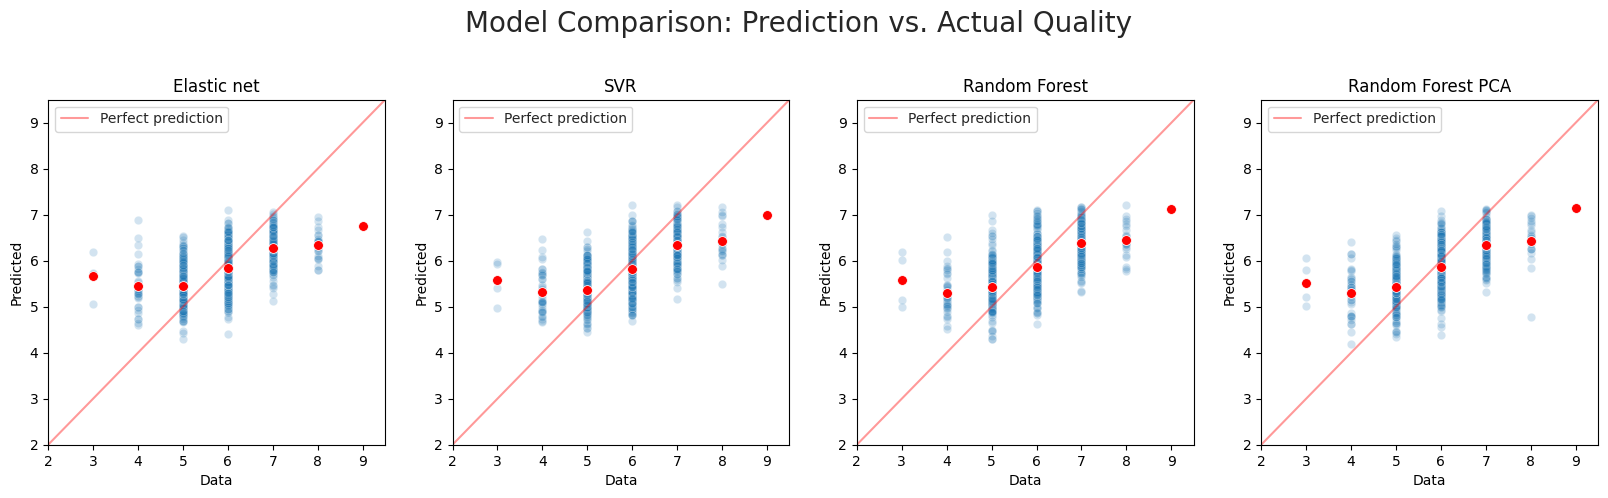

In [51]:
# Scatter plots

# Set up subplots
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
sns.set_style("whitegrid")

#create chart in each subplot
for ax, model in enumerate(predictions['Model'].unique()):
  axes[ax].set_title(model)
  predictions_model = predictions[predictions['Model'] == model]
  axes[ax].axline((0, 0), slope=1., color='red', label='Perfect prediction', alpha=0.4)
  sns.scatterplot(data=predictions_model, x='Data', y='Predicted', alpha=0.2, ax=axes[ax])
  sns.scatterplot(data=predictions_model['Predicted'].groupby(predictions_EN['Data']).mean().reset_index(), x='Data', y='Predicted', ax=axes[ax], color = 'red', s=50)
  axes[ax].set_ylim(2, 9.5)
  axes[ax].set_xlim(2, 9.5)
fig.subplots_adjust(top=0.8)
plt.suptitle('Model Comparison: Prediction vs. Actual Quality', fontsize=20)
plt.show()

This figure shows the relationship between predicted and actual wine quality for each model. Each blue dot represents one prediction. The red dots show the mean for each quality class. The red diagonal line represents an optimal prediction, i.e. if predictions were perfect they should all lie on this line.

It is very obvious, that that the three quality classes in the middle (5, 6, 7) were predicted quite well (dots are clsoe to the line), whereas the more extreme quality classes deviate a lot (the quality predictions for low quality wine were too high, whereas the predictions for high quality wine were too low).

In line with the performance metrics, the figure suggests that most models performed similarly well. The figure reveals that improved model performance of the more complex models compared to the Elasti net model was probably based on better performance in the more extreme quality classes (the dots are slightly closer to the red optimal line).

Since the differences between the model prediction are rather difficult to spot, I am creating a second type of figure which shows the distribution of predicted values for each quality class.

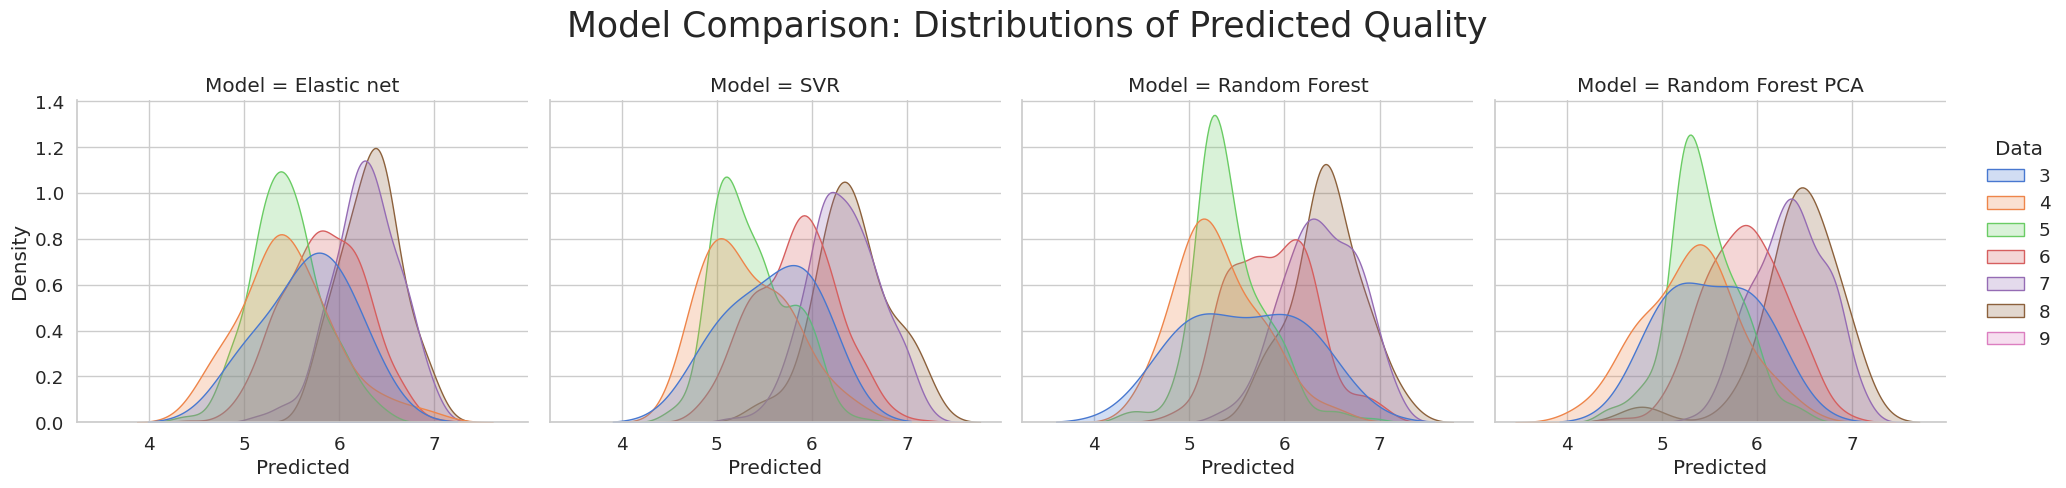

In [52]:
# Distributions of predictions for each quality class (by model)
sns.set(font_scale=1.2)
sns.set_style("whitegrid")
dis = sns.displot(data = predictions, x='Predicted', hue='Data', kind='kde', col='Model',fill=True, palette='muted',common_norm=False, warn_singular=False)
dis.fig.subplots_adjust(top=.8)
dis.fig.suptitle('Model Comparison: Distributions of Predicted Quality', fontsize=25)
plt.show()

This figure shows the distribution of predicted values for each quality class for each model. For all models, the distribution for quality rating of 3 is actually centered around 5 to 6, which again demonstrates that the prediction of this class was very inaccurate, probably due to the low number of data points. We can see that the predictions were most accurate for the classes in the middle, i.e. 5, 6, and 7. In general, all predictions seem to be biased towards the centre. Please note that there was only one data point with a quality of 9, therefore the distribution for this class cannot be plotted.

While all models show similar baises in the prediction of very low and high values, this figure suggests that with increasing model complexity, the prediction of very low and high values becomes more accurate (slightly lower predicted values for 3 (blue), and slighly higher values for 8 (brown).



## 3. Examination of predictors in the best model

The aim of this project to test how well wine quality can be predicted based on chemical properties, but also to investigate which properties have the highest predictive value. To answer this question, I am examining which predictors were most useful in the best model. According to the varianced explained and MSE the Random Forest Regression model provided the best fit. I will therefore visualise feature importance and an example decision tree below.

In [53]:
# Extract feature importance and display as table

feature_importances = forest_grid_search.best_estimator_.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

feature_importance_df.head()

,Feature,Importance
10,alcohol,0.303461
1,volatile acidity,0.115396
12,proportion free sulphur dioxide,0.086870
9,sulphates,0.073749
5,free sulfur dioxide,0.061983


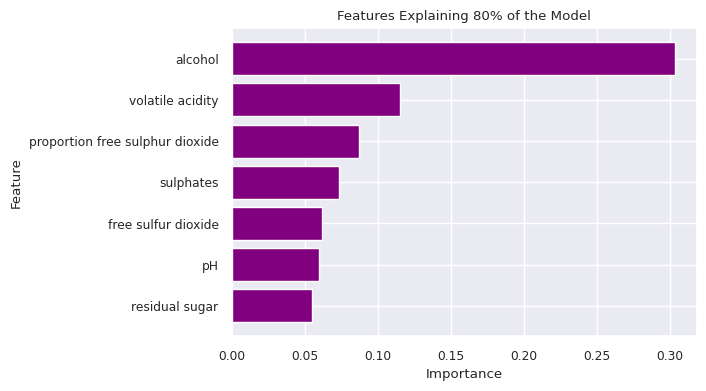

In [61]:
# Plot feature importance
feature_importance_df['Cumulative Importance'] = feature_importance_df['Importance'].cumsum()
important_features_80 = feature_importance_df[feature_importance_df['Cumulative Importance'] <= 0.80]

# Plot the important features
sns.set(font_scale=0.8)
plt.figure(figsize=(6, 4))
plt.barh(important_features_80['Feature'], important_features_80['Importance'], color='purple')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Features Explaining 80% of the Model')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.show()

The table and figure show the feature importance of the features that contribute 80% of the model prediction. We can see that only 7 out of 13 features (less than 50%) are necessary to account for 80% of the model performance. Alcohol stands out as the most important feature, with a feature importance estimated to be close to three times as high as the second most important feature (volatile acidity). Interestingly, the third most important feature is the proportion of free sulphur dioxide, the variable I created from two existing variables in the preprocessing section. This confirms my assumption that the proportion might be more meaningful than the absolute value of free sulphur dioxide.

Below, I am plotting an example decision tree to illustrate how the decision-making process is modelled. In line with the feature importance analysis presented above, the alcohol content determines the decision in the first node of the tree. Other features with high importance (such as volatile acidity and proportion of free sulphur dioxide) are represented further down in the decision prcoess. Please note that this is only one example decision tree from 110 different decision trees included in the Random Forest Regression model.

One of my hypotheses was that the type of wine might be important for quality prediction, since the relationship of chemical properties and quality might differ by wine type. However, none of my analyses indicates that wine type might play a significant role in quality prediction.

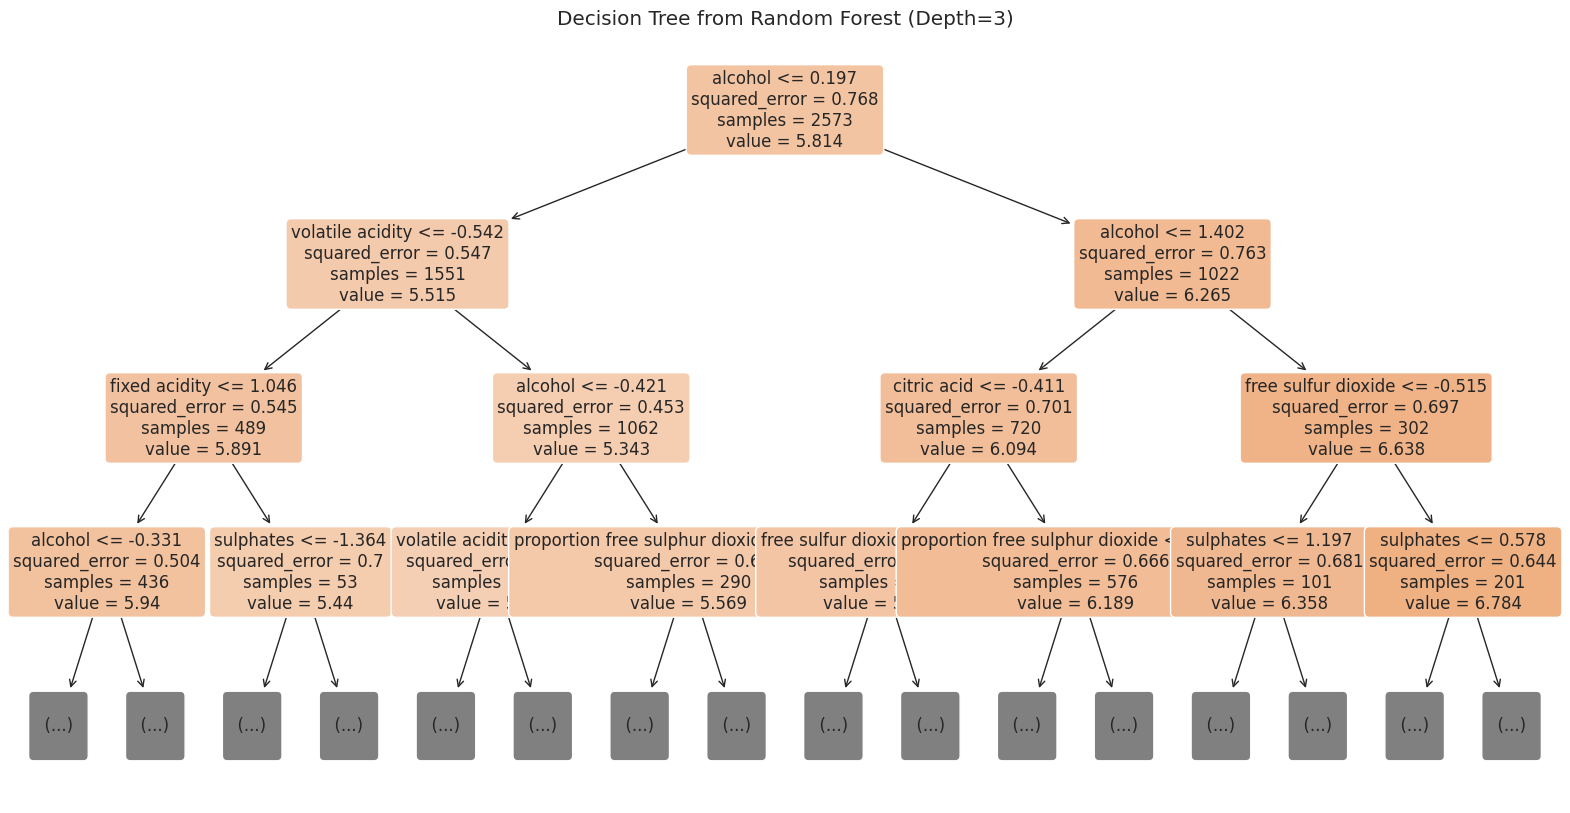

In [ ]:
# Plot decision tree
single_tree = forest_grid_search.best_estimator_.estimators_[0]
max_depth = 3 # Set the maximum depth for the plot for readability
plt.figure(figsize=(20, 10))
plot_tree(single_tree, feature_names=X.columns, class_names=['No Churn', 'Churn'], filled=True, rounded=True, fontsize=12, max_depth=max_depth)
plt.title(f'Decision Tree from Random Forest (Depth={max_depth})')
plt.show();

# VI. Discussion & Conclusions

The aim of this project was (1) to test how well wine quality can be predicted based on chemical proporties, and (2) which chemical properties most strongly contribute to wine quality.

I fitted four different ML regression models to the data which I compared to a very simple baseline model (linear regression). The baseline model was able to explain around 33% of the variance in the wine quality ratings. The Elastic Net model did not improve performance any further, suggesting that L1 and L2 regularisation did not have any positive effect. The Support Vector Regression model and Random Forest Regression model both increased explained variance to around 40%, demonstrating that these more complex models were better at capturing the patterns in the data. Reducing dimensionality with PCA in the Random Forest Regression model did not increase performance any further.

Taken together, these findings suggest that the chemical properties included in this dataset can explain around 40% of the variance in wine quality. This number might seem relatively low, given how well famous ML algorithms perform nowadays (on other ML problems). However, wine quality is certainly a very complex subjective experience that might be difficult to explain using basic chemical properties, therefore it is interesting to see that a substantial propertion of variance can be explained based on just 13 chemical properties.

My analysis of feature importance suggested that 7 of the 13 properties contributed 80% of model performance. Alcohol was by far the best predictor, followed by volatile acidity and proportion of free sulphur dioxide. The latter demonstrates that the creation of new variables in the pre-processing can be helpful for optimising ML algorithms.

**Suggestions for improvement:**

Model prediction can certainly be improved by adding more predictor variables to the dataset. SVR and Random Forest algorithms can capture complex relationships, therefore it might be very difficult to improve prediction based on just 13 features beyond the performance achieved with these models.
Having said that, it might be worth trying out other complex models such as Neural Networks which are known for their ability to capture complex relationships. Since the model predictions deviated the most for the underrepresented classes (i.e. very low and high values), it might also be a good idea to test whether oversampling of these classes might improve model prediction for these value ranges.

